# WEO data cleaning and reshaping

This notebook loads WEO data, filters to selected indicators, cleans numeric values, pivots to a panel (Country × Year) with indicators as columns, adds a global recession flag, drops incomplete years, and writes a cleaned CSV.

In [1]:
import pandas as pd
import csv
from pathlib import Path

p = Path(r"data.csv")
if not p.exists():
    raise FileNotFoundError(p)

# detect encoding (fallback to latin-1) and sample for delimiter sniffing
encoding = "utf-8"
try:
    sample = p.read_text(encoding=encoding)[:8192]
except UnicodeDecodeError:
    encoding = "latin-1"
    sample = p.read_text(encoding=encoding)[:8192]

try:
    delim = csv.Sniffer().sniff(sample).delimiter
except Exception:
    delim = ","

df = pd.read_csv(p, sep=delim, encoding=encoding, low_memory=False, parse_dates=True)
print("shape:", df.shape)
df.head()

shape: (8626, 61)


,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2022,2023,2024,2025,2026,2027,2028,2029,2030,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,032.712","1,056.123",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,Units,"See notes for: Gross domestic product, consta...",NaN,...,-6.240,2.267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,283.442","1,350.910",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,14.501,17.248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,86.149,91.272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0


## 1) Load CSV

Detect encoding and delimiter, then read the CSV into a DataFrame. This cell expects a local `data.csv` file.

In [2]:
Unique_Country = df['Country'].unique()

## 2) Inspect countries

Quick check to list unique country names so you can verify formatting and spot duplicates or unexpected values.

In [3]:
# count columns
print("Number of columns:", df.shape[1])

# list column names
print("Columns:", df.columns.tolist())

# counts of non-null values per column (good for spotting missing data)
print(df.count().sort_values(ascending=False))
# count columns
print("Number of columns:", df.shape[1])

# list column names
print("Columns:", df.columns.tolist())

# counts of non-null values per column (good for spotting missing data)
print(df.count().sort_values(ascending=False))

Number of columns: 61
Columns: ['WEO Country Code', 'ISO', 'WEO Subject Code', 'Country', 'Subject Descriptor', 'Subject Notes', 'Units', 'Scale', 'Country/Series-specific Notes', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', 'Estimates Start After']
WEO Country Code      8625
ISO                   8624
WEO Subject Code      8624
Country               8624
Subject Descriptor    8624
                      ... 
1984                  4104
1983                  4079
1982                  4039
1981                  3995
1980                  3861
Length: 61, dtype: int64
Number of columns: 61
Columns: ['WEO Country Code', 'ISO', 'WEO S

## 3) Column overview

Show number of columns, column names and non-null counts to locate missing-data-heavy columns that may need attention.

In [4]:
df.drop(columns=["WEO Country Code", "ISO","Country/Series-specific Notes", "Subject Notes", "Units", "Scale", "Estimates Start After", "Subject Descriptor" ], inplace=True)

codes = {"NGDPD","PCPI","TM_RPCH","TX_RPCH","LUR","LP","GGR_NGDP","GGX_NGDP","GGXWDN_NGDP","BCA_NGDPD"}
col = "WEO Subject Code"

if col not in df.columns:
    raise KeyError(f"Column {col!r} not found in dataframe")

df = df[df[col].astype(str).str.strip().isin(codes)].copy()
print("shape after filter:", df.shape)
df

shape after filter: (1960, 53)


,WEO Subject Code,Country,1980,1981,1982,1983,1984,1985,1986,1987,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
3,NGDPD,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.278,14.501,17.248,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,PCPI,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,130.038,143.822,132.728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,TM_RPCH,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-30.012,29.820,14.971,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,TX_RPCH,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.529,30.217,-2.680,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,LUR,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8606,LP,Zimbabwe,7.092,7.300,7.606,7.849,8.099,8.385,8.648,8.919,...,15.904,16.229,16.624,16.993,17.360,17.729,18.104,18.488,18.882,19.285
8608,GGR_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.348,16.599,14.649,16.581,18.549,18.698,19.117,19.197,19.277,19.277
8610,GGX_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.573,21.476,19.968,18.641,19.053,18.257,18.231,18.201,18.143,18.110
8618,GGXWDN_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4) Filter indicators and drop unused columns

We drop metadata columns and filter rows to the indicator codes of interest (NGDPD, PCPI, ...). Keep an eye on column names — mismatches will raise a KeyError.

In [5]:
# --- Step 1: Identify year columns ---
year_cols = df.columns[2:]  # after WEO Subject Code and Country

# --- Step 2: Clean numeric formatting ---
df[year_cols] = df[year_cols].replace({',': ''}, regex=True)
df[year_cols] = df[year_cols].apply(pd.to_numeric, errors="coerce")

# --- Step 3: Clean country names ---
df["Country"] = (
    df["Country"]
    .str.replace(" ", "_")
    .str.replace("'", "")
    .str.replace("-", "_")
)

# --- Step 4: Melt into long format ---
df_long = df.melt(id_vars=["WEO Subject Code", "Country"],
                  var_name="Year", value_name="Value")

# --- Step 5: Keep only valid year rows ---
df_long["Year"] = df_long["Year"].astype(str).str.strip()
df_long = df_long[df_long["Year"].str.fullmatch(r"\d{4}")].copy()
df_long["Year"] = df_long["Year"].astype(int)

# --- Step 6: Clean numeric values ---
df_long["Value"] = (
    df_long["Value"].astype(str)
    .str.replace(",", "")
    .replace({"": None, "nan": None})
    .astype(float)
)

# --- Step 7: Pivot using WEO Subject Code as columns ---
df_pivot = df_long.pivot_table(
    index=["Country", "Year"],
    columns="WEO Subject Code",   # use NGDPD, PCPI, etc.
    values="Value",
    aggfunc="first"
).reset_index()

# --- Step 8: Finalize ---
df_pivot.columns.name = None
df_pivot = df_pivot.set_index("Year")

df_pivot.head()


,Country,BCA_NGDPD,GGR_NGDP,GGXWDN_NGDP,GGX_NGDP,LP,LUR,NGDPD,PCPI,TM_RPCH,TX_RPCH
Year,,,,,,,,,,,
2002,Afghanistan,33.908,6.845,NaN,6.943,21.000,NaN,4.367,31.263,NaN,NaN
2003,Afghanistan,29.616,9.826,NaN,11.927,22.645,NaN,4.553,42.413,36.222,49.541
2004,Afghanistan,37.216,12.676,NaN,15.069,23.554,NaN,5.146,49.351,-0.427,-8.436
2005,Afghanistan,30.226,14.733,NaN,15.651,24.411,NaN,6.167,54.566,55.010,41.968
2006,Afghanistan,20.844,18.946,NaN,18.262,25.443,NaN,6.925,58.269,-2.198,-6.919


## 5) Clean numeric values, standardize country names, and reshape

Steps:
- Identify year columns and coerce them to numeric (remove commas).
- Standardize country strings to avoid duplication (underscores, remove quotes/hyphens).
- Melt to long format (WEO Subject Code, Country, Year, Value).
- Keep only rows where Year looks like YYYY and ensure Value is numeric.
- Pivot so each row is Country × Year and columns are indicators.

If duplicate (Country, Year, Indicator) rows exist, the code uses `aggfunc='first'`. Inspect duplicates if results look wrong.

In [6]:
# Convert Year index to integer
df_pivot.index = df_pivot.index.astype(int)

# Define global recession years
global_recession_years = [
    1981, 1982, 1983,
    1990, 1991, 1992, 1993,
    2008, 2009, 2010,
    2020, 2021
]

# Add Global_Recession column
df_pivot["Global_Recession"] = df_pivot.index.isin(global_recession_years).astype(int)

df_pivot


,Country,BCA_NGDPD,GGR_NGDP,GGXWDN_NGDP,GGX_NGDP,LP,LUR,NGDPD,PCPI,TM_RPCH,TX_RPCH,Global_Recession
Year,,,,,,,,,,,,
2002,Afghanistan,33.908,6.845,NaN,6.943,21.000,NaN,4.367,31.263,NaN,NaN,0
2003,Afghanistan,29.616,9.826,NaN,11.927,22.645,NaN,4.553,42.413,36.222,49.541,0
2004,Afghanistan,37.216,12.676,NaN,15.069,23.554,NaN,5.146,49.351,-0.427,-8.436,0
2005,Afghanistan,30.226,14.733,NaN,15.651,24.411,NaN,6.167,54.566,55.010,41.968,0
2006,Afghanistan,20.844,18.946,NaN,18.262,25.443,NaN,6.925,58.269,-2.198,-6.919,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2026,Zimbabwe,3.063,18.698,NaN,18.257,17.729,NaN,39.491,1204688.561,NaN,NaN,0
2027,Zimbabwe,2.927,19.117,NaN,18.231,18.104,NaN,40.925,1300690.916,NaN,NaN,0
2028,Zimbabwe,2.895,19.197,NaN,18.201,18.488,NaN,42.340,1404343.758,NaN,NaN,0


## 6) Add global recession flag

Convert the Year index to integer and add a `Global_Recession` column marking selected years. Adjust the list of recession years if your definition differs.

In [7]:
# Remove rows with any NaN values
df_pivot = df_pivot.dropna()
df_pivot

,Country,BCA_NGDPD,GGR_NGDP,GGXWDN_NGDP,GGX_NGDP,LP,LUR,NGDPD,PCPI,TM_RPCH,TX_RPCH,Global_Recession
Year,,,,,,,,,,,,
2011,Albania,-12.765,25.108,57.474,28.583,2.905,14.0,13.052,92.892,3.639,1.013,0
2012,Albania,-10.082,24.497,59.865,27.897,2.900,13.4,12.470,94.783,-7.604,-0.407,0
2013,Albania,-9.144,23.696,67.444,28.849,2.895,15.9,12.936,96.608,-0.612,8.288,0
2014,Albania,-10.670,25.963,64.766,31.356,2.889,17.5,13.404,98.167,5.418,3.199,0
2015,Albania,-8.508,26.129,67.993,30.396,2.881,17.1,11.525,100.000,0.070,5.908,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2026,Uruguay,-1.662,28.217,59.226,30.919,3.520,8.0,85.164,120.333,5.311,3.505,0
2027,Uruguay,-1.826,28.169,59.041,30.753,3.528,8.0,90.702,126.028,5.100,3.432,0
2028,Uruguay,-1.875,28.160,58.910,30.572,3.535,8.0,96.223,131.862,5.022,3.371,0


## 7) Remove incomplete rows

Dropping all rows with any NaN removes years/countries that lack any indicator value. Consider imputing or relaxing this if you need more coverage.

In [8]:
df_pivot["Country"].unique()

array(['Albania', 'Algeria', 'Australia', 'Austria', 'Barbados',
       'Belgium', 'Bolivia', 'Bosnia_and_Herzegovina', 'Brazil',
       'Bulgaria', 'Cabo_Verde', 'Canada', 'Chile', 'Colombia',
       'Costa_Rica', 'Croatia', 'Cyprus', 'Czech_Republic', 'Denmark',
       'Dominican_Republic', 'Egypt', 'Estonia', 'Finland', 'France',
       'Germany', 'Hungary', 'Iceland', 'Indonesia', 'Ireland',
       'Islamic_Republic_of_Iran', 'Israel', 'Italy', 'Japan', 'Jordan',
       'Kazakhstan', 'Korea', 'Latvia', 'Lebanon', 'Lithuania',
       'Luxembourg', 'Malta', 'Mexico', 'Morocco', 'Netherlands',
       'New_Zealand', 'Nigeria', 'North_Macedonia', 'Norway', 'Pakistan',
       'Panama', 'Paraguay', 'Peru', 'Poland', 'Portugal', 'Romania',
       'Saudi_Arabia', 'Serbia', 'Seychelles', 'Slovak_Republic',
       'Slovenia', 'South_Africa', 'Spain', 'Sweden', 'Switzerland',
       'Syria', 'Taiwan_Province_of_China', 'Trinidad_and_Tobago',
       'Türkiye', 'United_Kingdom', 'United_States',

In [9]:
df_filtered = df_pivot.loc[df_pivot.index <= 2024]
df_filtered

,Country,BCA_NGDPD,GGR_NGDP,GGXWDN_NGDP,GGX_NGDP,LP,LUR,NGDPD,PCPI,TM_RPCH,TX_RPCH,Global_Recession
Year,,,,,,,,,,,,
2011,Albania,-12.765,25.108,57.474,28.583,2.905,14.000,13.052,92.892,3.639,1.013,0
2012,Albania,-10.082,24.497,59.865,27.897,2.900,13.400,12.470,94.783,-7.604,-0.407,0
2013,Albania,-9.144,23.696,67.444,28.849,2.895,15.900,12.936,96.608,-0.612,8.288,0
2014,Albania,-10.670,25.963,64.766,31.356,2.889,17.500,13.404,98.167,5.418,3.199,0
2015,Albania,-8.508,26.129,67.993,30.396,2.881,17.100,11.525,100.000,0.070,5.908,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020,Uruguay,-0.641,28.152,57.414,32.815,3.478,10.350,53.557,83.003,-11.662,-17.842,1
2021,Uruguay,-2.433,27.601,54.152,30.222,3.485,9.375,60.742,89.436,18.358,26.180,1
2022,Uruguay,-3.789,27.475,51.256,29.996,3.492,7.867,70.600,97.580,14.019,4.006,0


In [10]:
# Assuming df_filtered is your dataframe with Year as index
X = df_filtered.drop(columns=["Global_Recession", "Country"])  # features
y = df_filtered["Global_Recession"]                           # target


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

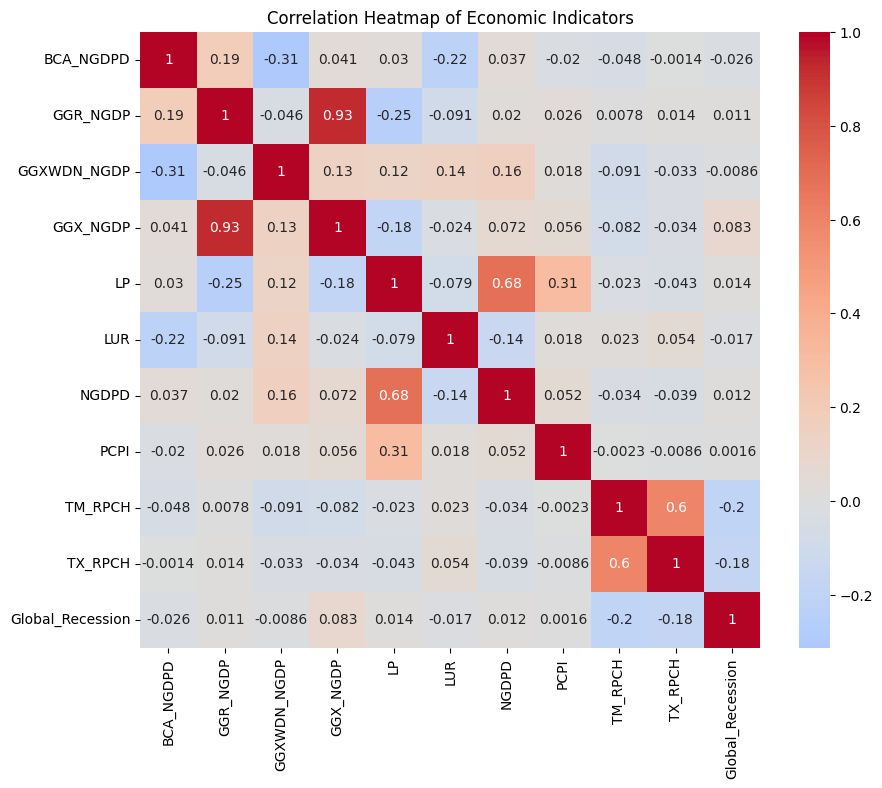

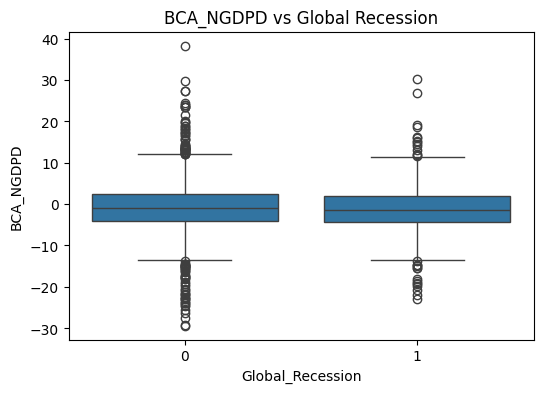

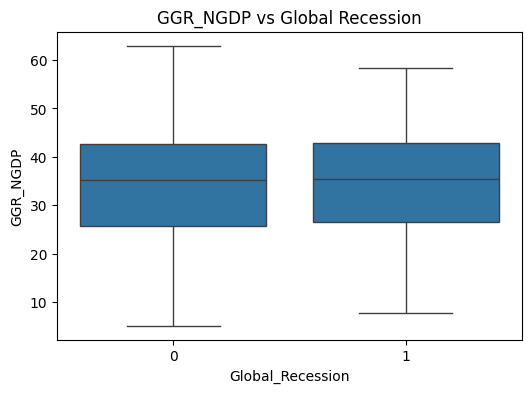

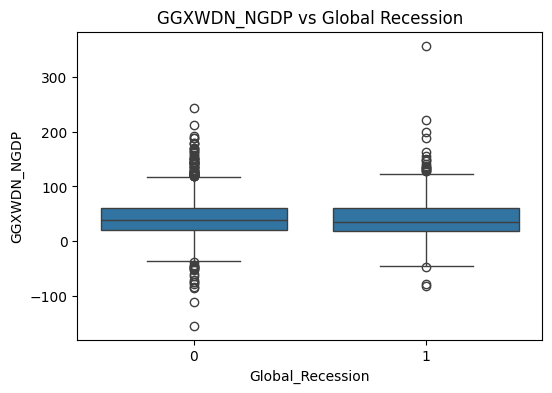

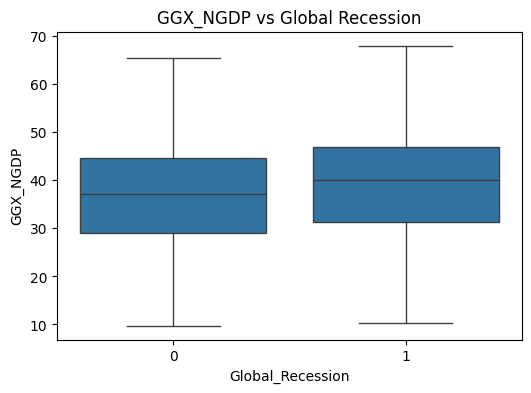

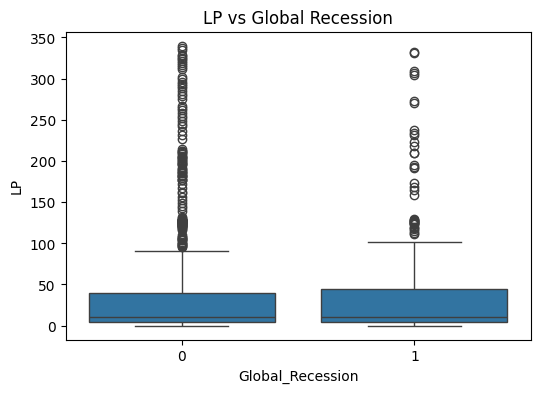

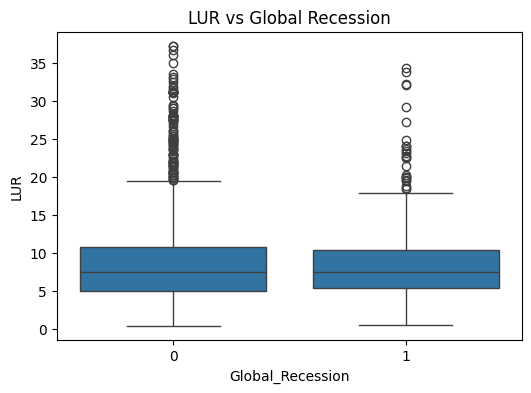

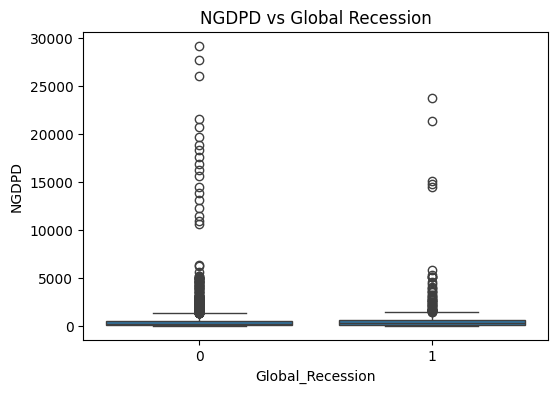

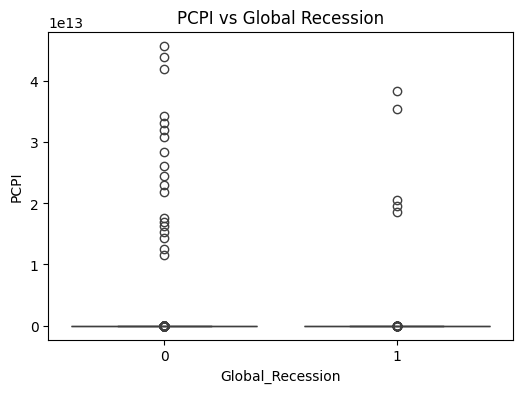

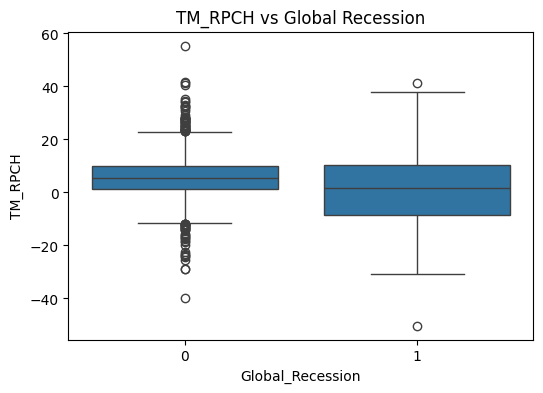

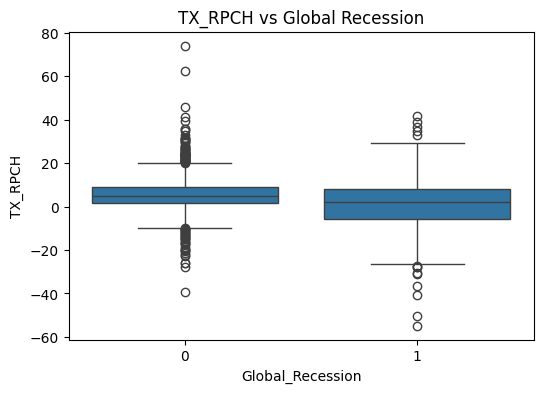

In [12]:
# --- 3. Exploratory Plots ---
# Heatmap
plt.figure(figsize=(10,8))
corr = df_filtered.drop(columns=["Country"]).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Economic Indicators")
plt.show()

# Boxplots for all features vs Global_Recession
features = X.columns
for feature in features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Global_Recession", y=feature, data=df_filtered)
    plt.title(f"{feature} vs Global Recession")
    plt.show()

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


              precision    recall  f1-score   support

           0       0.79      1.00      0.88       317
           1       0.00      0.00      0.00        83

    accuracy                           0.79       400
   macro avg       0.40      0.50      0.44       400
weighted avg       0.63      0.79      0.70       400

Logistic Regression Feature Importance:
       Feature   Coefficient  Abs_Importance
7         PCPI -3.864198e-14    3.864198e-14
6        NGDPD -5.034171e-22    5.034171e-22
2  GGXWDN_NGDP -2.999465e-23    2.999465e-23
3     GGX_NGDP -2.507573e-23    2.507573e-23
1     GGR_NGDP -2.411207e-23    2.411207e-23
4           LP -2.268452e-23    2.268452e-23
5          LUR -6.289183e-24    6.289183e-24
8      TM_RPCH -5.344255e-24    5.344255e-24
9      TX_RPCH -5.012813e-24    5.012813e-24
0    BCA_NGDPD  4.605818e-25    4.605818e-25


c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

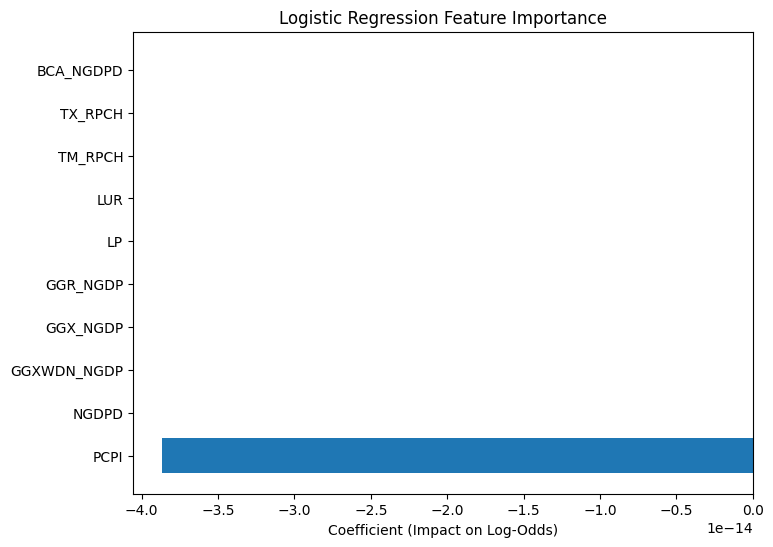

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Logistic Regression coefficients
coefficients = model.coef_[0]
features = X_train.columns

logit_importance = pd.DataFrame({
    "Feature": features,
    "Coefficient": coefficients,
    "Abs_Importance": np.abs(coefficients)
}).sort_values(by="Abs_Importance", ascending=False)

print("Logistic Regression Feature Importance:")
print(logit_importance)

# Plot
plt.figure(figsize=(8,6))
plt.barh(logit_importance["Feature"], logit_importance["Coefficient"])
plt.xlabel("Coefficient (Impact on Log-Odds)")
plt.title("Logistic Regression Feature Importance")
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       317
           1       0.77      0.24      0.37        83

    accuracy                           0.83       400
   macro avg       0.80      0.61      0.63       400
weighted avg       0.82      0.83      0.79       400

Random Forest Feature Importance:
       Feature  Importance
8      TM_RPCH    0.176770
9      TX_RPCH    0.165429
7         PCPI    0.107630
3     GGX_NGDP    0.092350
0    BCA_NGDPD    0.081423
6        NGDPD    0.081367
1     GGR_NGDP    0.077755
2  GGXWDN_NGDP    0.076835
5          LUR    0.071798
4           LP    0.068642


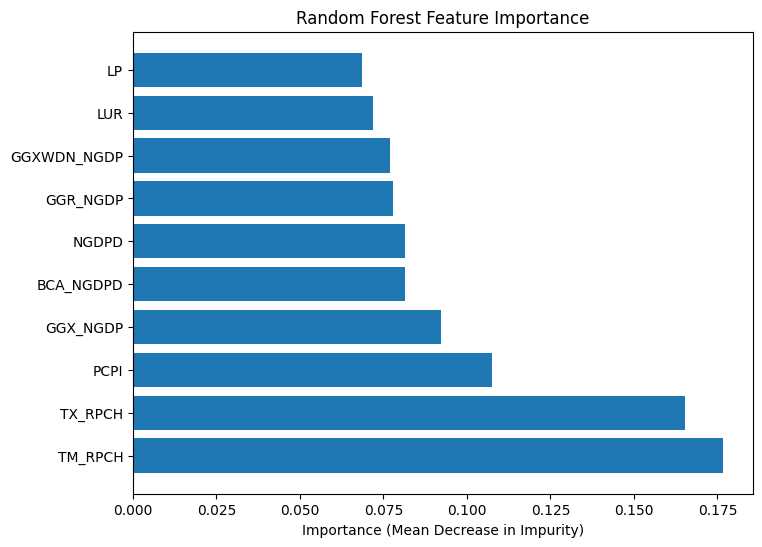

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

# Random Forest feature importance
rf_importance = pd.DataFrame({
    "Feature": features,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("Random Forest Feature Importance:")
print(rf_importance)

# Plot
plt.figure(figsize=(8,6))
plt.barh(rf_importance["Feature"], rf_importance["Importance"])
plt.xlabel("Importance (Mean Decrease in Impurity)")
plt.title("Random Forest Feature Importance")
plt.show()


In [16]:
# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print("Gradient Boosting:\n", classification_report(y_test, y_pred))

gb_importance = pd.DataFrame({
    "Feature": features,
    "Importance": gb.feature_importances_
}).sort_values(by="Importance", ascending=False)

gb_importance

Gradient Boosting:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90       317
           1       0.74      0.28      0.40        83

    accuracy                           0.83       400
   macro avg       0.79      0.63      0.65       400
weighted avg       0.82      0.83      0.80       400



,Feature,Importance
8,TM_RPCH,0.295878
9,TX_RPCH,0.170762
7,PCPI,0.166194
3,GGX_NGDP,0.092824
6,NGDPD,0.072210
2,GGXWDN_NGDP,0.053285
1,GGR_NGDP,0.045793
0,BCA_NGDPD,0.041968
5,LUR,0.030921
4,LP,0.030165


In [ ]:
from sklearn.svm import LinearSVC

linear_svm = LinearSVC(random_state=42, max_iter=5000)
linear_svm.fit(X_train, y_train)

svm_importance = pd.DataFrame({
    "Feature": features,
    "Coefficient": linear_svm.coef_[0],
    "Abs_Importance": np.abs(linear_svm.coef_[0])
}).sort_values(by="Abs_Importance", ascending=False)

print(svm_importance)



In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("KNN:\n", classification_report(y_test, y_pred))

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print("Naive Bayes:\n", classification_report(y_test, y_pred))
# No direct feature importance

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print("MLP:\n", classification_report(y_test, y_pred))

In [ ]:
# Compare feature importance for models that support it
fig, axes = plt.subplots(1, 3, figsize=(18,6))

sns.barplot(x="Abs_Importance", y="Feature", data=logit_importance, ax=axes[0])
axes[0].set_title("Logistic Regression Coefficients")

sns.barplot(x="Importance", y="Feature", data=rf_importance, ax=axes[1])
axes[1].set_title("Random Forest Importance")

sns.barplot(x="Importance", y="Feature", data=gb_importance, ax=axes[2])
axes[2].set_title("Gradient Boosting Importance")

plt.tight_layout()
plt.show()


## 8) Export

Write the cleaned panel to CSV for downstream analysis or modeling.

In [ ]:
# Write dataframe to CSV
df_pivot.to_csv("weo_data_clean.csv", index=True)
